In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import functorch
import matplotlib.pyplot as plt

import os
from datetime import datetime
import time

import Double_Pendulum.Lumped_Mass.robot_parameters as robot_parameters
import Double_Pendulum.Lumped_Mass.transforms as transforms
import Double_Pendulum.Lumped_Mass.dynamics as dynamics
import Learning.loss_terms as loss_terms
import Plotting.plotters_h1h2 as plotters_h1h2
import Learning.training_data as training_data

%load_ext autoreload
%autoreload 2


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
rp = robot_parameters.LUMPED_PARAMETERS
print(rp)
import Plotting.theta_visualiser as theta_visualizer

mapping_functions = (transforms.analytic_theta_1, transforms.analytic_theta_2)
th_plotter = theta_visualizer.theta_plotter(rp=rp, n_lines=50, mapping_functions=mapping_functions)
#th_plotter.make_figure("theta_subset_5_2_image.png")
#th_plotter.make_animation("theta_subset_5_2.mp4", duration = 4, fps = 20, stride = 1)


cuda
{'l1': 3.1, 'l2': 2.0, 'm': 3.0, 'g': 9.81, 'xa': 5.0, 'ya': 2.0}


For plotting I currently have the following code:

fig, ax = plt.subplots(figsize=(11.69, 8.27), dpi=400)
for i in range(0, Theta1.shape[1]):  # Draw fewer lines for clarity
        ax.plot(Theta1[i, :], Theta2[i, :], color='black', lw=0.2, alpha=0.9)
        ax.plot(Theta1[:, i], Theta2[:, i], color='black', lw=0.2, alpha=0.9)
    output_path = "Plotting/Plots/test_wallpaper.png"
    plt.savefig(output_path, dpi=400, bbox_inches='tight', pad_inches=0, facecolor=fig.get_facecolor())
    plt.show()
    plt.close(fig)


Instead of a single image I would like to create an mp4 animation.Every frame I want it to slowly morph from the original coordinates to the new ones, somethign like this:


    plot_Theta1 = (100-frame) * q1_grid + frame * Theta1
    plot_Theta2 = (100-frame) * q2_grid + frame * Theta2


How can I do so, and then make the animation?


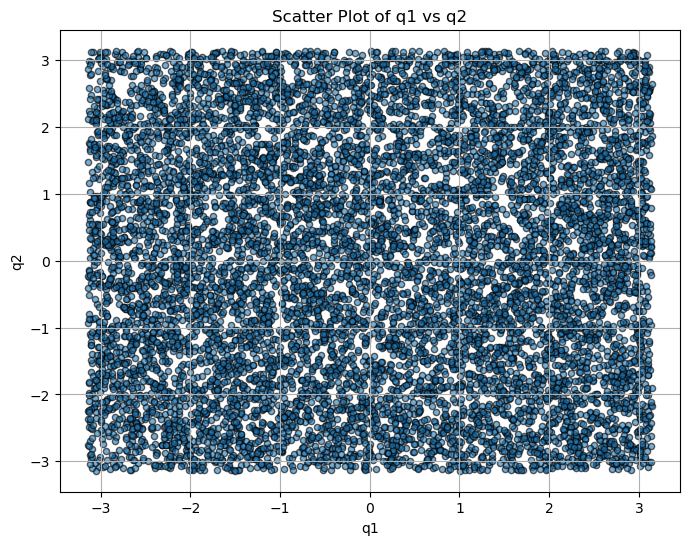

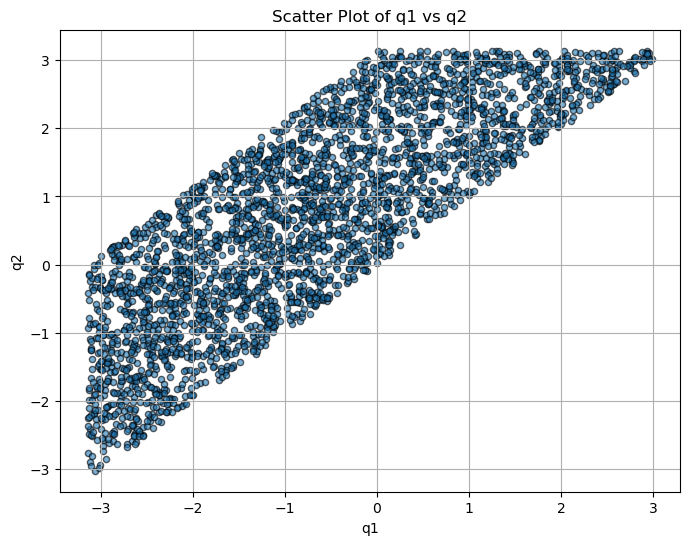

In [3]:
import numpy as np


# Retrieve training points
points = training_data.points.to(device)

# Plot q1 vs q2
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0].cpu().numpy(), points[:, 1].cpu().numpy(), alpha=0.6, edgecolors='k', s=20)
plt.title('Scatter Plot of q1 vs q2')
plt.xlabel('q1')
plt.ylabel('q2')
plt.grid(True)
plt.show()


valid_mask = ((points[:,1] >= points[:,0] + torch.pi * 1/10) & (points[:,1] <= points[:,0] + torch.pi * 9/10))
points = points[valid_mask]
points = points[0:3000]

plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0].cpu().numpy(), points[:, 1].cpu().numpy(), alpha=0.6, edgecolors='k', s=20)
plt.title('Scatter Plot of q1 vs q2')
plt.xlabel('q1')
plt.ylabel('q2')
plt.grid(True)
plt.show()

In [4]:
# Compute mass- and input matrix of all training points to reduce load in training

data_pairs = []
for point in points:
    Mq_point, _, _ = dynamics.dynamical_matrices(rp, point, point)
    Aq_point = dynamics.input_matrix(rp, point)
    data_pairs.append((point, Mq_point, Aq_point))

points_tensor = torch.stack([pair[0] for pair in data_pairs])           # Tensor of all points
mass_matrices_tensor = torch.stack([pair[1] for pair in data_pairs])   # Tensor of all mass matrices
input_matrices_tensor = torch.stack([pair[2] for pair in data_pairs])  # Tensor of all input matrices

# Create TensorDataset
dataset = TensorDataset(points_tensor, mass_matrices_tensor, input_matrices_tensor)
print(len(dataset))


3000


In [5]:
# Split into training and test sets (80% train, 20% test)

batch_size = 512
train_part = 0.7

train_size = int(train_part * len(points))
val_size = len(points) - train_size


# Create TensorDataset for both training and testing sets
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create the DataLoader for both training and testing sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


##Iterate through the DataLoader
#for batch in train_dataloader:
    #print(batch[0])
    #break  # Just to show one batch

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, rp):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.Softplus(),
            nn.Linear(16, 16),
            nn.Softplus(),
            nn.Linear(16, 2)
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.Softplus(),
            nn.Linear(16, 16),
            nn.Softplus(),
            nn.Linear(16, 2)
        )
        
        self.rp = rp
        
    def encoder_theta_1_ana(self, q):
        theta_1 = transforms.analytic_theta_1(self.rp, q).unsqueeze(0)
        return theta_1, theta_1
    
    #This function is not used in the forward pass, but is useful for comparing learned to analytic theta_2
    def encoder_theta_2_ana(self, q):
        theta_2 = transforms.analytic_theta_2(self.rp, q).unsqueeze(0)
        return theta_2, theta_2
    
    def theta_ana(self, q):
        theta_1_ana, _ = torch.vmap(self.encoder_theta_1_ana)(q)
        theta_2_ana, _ = torch.vmap(self.encoder_theta_2_ana)(q)
        theta_ana = torch.cat((theta_1_ana, theta_2_ana), dim=1)
        return theta_ana

    def encoder_nn(self, q):
        theta = self.encoder(q)
        return theta, theta
    
    def decoder_nn(self, theta):
        q_hat = self.decoder(theta)
        return q_hat, q_hat
    
    def forward(self, q):
        
        J_h_1_ana, theta_1_ana = torch.vmap(torch.func.jacfwd(self.encoder_theta_1_ana, has_aux=True))(q)
        J_h_2_ana, theta_2_ana = torch.vmap(torch.func.jacfwd(self.encoder_theta_2_ana, has_aux=True))(q)
        J_h_ana = torch.cat((J_h_1_ana, J_h_2_ana), dim=1).float()
        
        
        J_h, theta = torch.vmap(torch.func.jacfwd(self.encoder_nn, has_aux=True))(q)

        J_h_dec, q_hat = torch.vmap(torch.func.jacfwd(self.decoder_nn, has_aux=True))(theta)

        return(theta, J_h, q_hat, J_h_dec, J_h_ana)

In [19]:
%%time
%matplotlib widget

current_time = datetime.now().strftime("%Y%m%d%H%M")
save_directory = os.path.join(os.getcwd(), "Models")
os.makedirs(save_directory, exist_ok=True)
file_name = f"Lumped_Mass_{current_time}.pth"
save_path = os.path.join(save_directory, file_name)
load_path = os.path.normpath("/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202411271337.pth")


rp = robot_parameters.LUMPED_PARAMETERS
num_epochs = 501

print(save_path)
model = Autoencoder(rp).to(device)  # Move model to GPU
#model.load_state_dict(torch.load(load_path, weights_only=True))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9 ** (1 / num_epochs))



/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202501142156.pth
CPU times: user 5.11 ms, sys: 3.93 ms, total: 9.04 ms
Wall time: 8.7 ms


In [20]:
import torch.nn.functional as F

def loss_fun(q, q_hat, m_matrix, input_matrix, J_h, J_h_dec):
    l_recon = F.mse_loss(q, q_hat, reduction="sum")
    J_h_inv = torch.transpose(J_h, 1, 2)
    J_h_trans = J_h_inv
    #J_h_trans = torch.transpose(J_h, 1, 2)
    #J_h_inv = J_h_dec
    #J_h_inv_trans = torch.transpose(J_h_inv, 1, 2)
    J_h_inv_trans = J_h
    
    J_ortho = J_h @ J_h_trans
    J_ortho_inv = J_h_inv @ J_h_inv_trans
    
    identity_matrix = J_h @ J_h_inv  # Batch-wise multiplication
    unitary_target = torch.eye(identity_matrix.size(-1), device=identity_matrix.device).expand(identity_matrix.size(0), -1, -1)


    # Enforce that decoder Jacobian is the inverse of the encoder Jacobian
    ## USE ONLY WHEN J_h_inv == J_h_dec
    #l_J_inv = torch.sum((torch.eye(identity_matrix.size(-1), device=identity_matrix.device) - identity_matrix)**2)  # Frobenius norm
    #l_J_ortho_inv = torch.sum((torch.eye(identity_matrix.size(-1), device=identity_matrix.device) - J_ortho_inv)**2)  # Frobenius norm\n",

    # Enforce that the Jacobian is orthogonal
    l_J_ortho = torch.sum((torch.eye(identity_matrix.size(-1), device=identity_matrix.device) - J_ortho)**2)  # Frobenius norm

    diag_matrix = J_h_inv_trans @ m_matrix @ J_h_inv  # Batch-wise diagonalization
    """
    # Enforce inertial decoupling (diagonal loss)
    off_dia = diag_matrix[:, 0, 1]
    trace = torch.einsum('bii->b', diag_matrix) 
    M_th_ratio = off_dia/trace
    l_diag = nn.MSELoss()(M_th_ratio, torch.zeros((M_th_ratio.size())).to(device))
    """
    
    # Enforce inertial decoupling
    ## Slight concern is that this sends all values of M_th to 0. Hopefully l_J_ortho avoids this
    l_diag = torch.sum(diag_matrix**2) - torch.sum(torch.diagonal(diag_matrix, dim1=1, dim2=2)**2)  # Penalize off-diagonal terms

    ## input decoupling loss
    input_x = J_h_inv_trans @ input_matrix
    l_input = torch.sum((input_x[:, 1]**2)) #+ torch.sum(((input_x[:, 0]-1)**2))

    loss = l_recon + l_diag + l_input + l_J_ortho #+ l_J_inv + l_J_ortho_inv
    loss_terms = torch.tensor([l_recon, l_J_ortho, l_diag, l_input])

    return loss, loss_terms

In [21]:
import torch.nn.functional as F

def loss_cheat(theta, theta_ana, J_h, J_h_ana, q, q_hat, J_h_dec):

    l_h_cheat = F.mse_loss(theta, theta_ana, reduction="sum")
    l_J_cheat = F.mse_loss(J_h, J_h_ana, reduction="sum")
    l_recon = F.mse_loss(q, q_hat, reduction="sum")
    identity_matrix = J_h @ J_h_dec  # Batch-wise multiplication
    l_J_inv = torch.sum((torch.eye(identity_matrix.size(-1), device=identity_matrix.device) - identity_matrix)**2)  # Frobenius norm

    loss = l_h_cheat + l_J_cheat + l_recon + l_J_inv
    loss_terms = torch.tensor([l_h_cheat, l_J_cheat, l_recon, l_J_inv, 0, 0])

    return loss, loss_terms

In [23]:


outputs = []
plt.ion()

train_losses = []
val_losses = []
start_time = time.time()

for epoch in range(num_epochs):

    # Training phase
    model.train()
    train_loss = 0
    train_loss_terms = torch.zeros(4)
    for index, (q, M_q, A_q) in enumerate(train_dataloader):
        #batch_size = batch[0].shape[0]
        q = q.to(device)
        #q.requires_grad = True
        #q_d = batch[0].to(device)

        M_q = M_q.to(device)
        A_q = A_q.to(device)
        
        theta, J_h, q_hat, J_h_dec, J_h_ana = model(q)  
        theta_ana = model.theta_ana(q)
                
        loss, loss_terms = loss_fun(q, q_hat, M_q, A_q, J_h, J_h_dec)
        #loss, loss_terms = loss_cheat(theta, theta_ana, J_h, J_h_ana, q, q_hat, J_h_dec)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_loss_terms += loss_terms
    train_loss /= len(train_dataloader.dataset)
    train_loss_terms /= len(train_dataloader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    val_loss_terms = torch.zeros(4)
    with torch.no_grad():
      for index, (q, M_q, A_q) in enumerate(val_dataloader):
        q = q.to(device)
        M_q = M_q.to(device)
        A_q = A_q.to(device)

        theta, J_h, q_hat, J_h_dec, J_h_ana = model(q)
        theta_ana = model.theta_ana(q)

        loss, loss_terms = loss_fun(q, q_hat, M_q, A_q, J_h, J_h_dec)
        #loss, loss_terms = loss_cheat(theta, theta_ana, J_h, J_h_ana, q, q_hat, J_h_dec)

        val_loss += loss.item()
        val_loss_terms += loss_terms
    val_loss /= len(val_dataloader.dataset)
    val_loss_terms /= len(val_dataloader.dataset)
    val_losses.append(val_loss)
    epoch_duration = time.time() - start_time
    scheduler.step()

    if epoch % 10 == 0:
        print(
            f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Duration: {epoch_duration:.2f} seconds'
            )

        print(
            f"recon: {val_loss_terms[0].item():.4f}, "
            f"J_ortho: {val_loss_terms[1].item():.4f}, "
            f"diag: {val_loss_terms[2].item():.4f}, "
            f"input: {val_loss_terms[3].item():.4f}"
        )
        """
        print(
            f"theta: {val_loss_terms[0].item():.4f}, "
            f"J_h: {val_loss_terms[1].item():.4f}, "
            f"recon: {val_loss_terms[2].item():.4f}, "
            f"J_inv: {val_loss_terms[3].item():.4f}, "
        )"""

Epoch [1/501], Training Loss: 1.3516, Validation Loss: 1.3338, Duration: 0.13 seconds
recon: 0.3279, J_ortho: 1.0023, diag: 0.0035, input: 0.0000
Epoch [11/501], Training Loss: 1.3653, Validation Loss: 1.3515, Duration: 1.43 seconds
recon: 0.3256, J_ortho: 1.0024, diag: 0.0235, input: 0.0001
Epoch [21/501], Training Loss: 1.3485, Validation Loss: 1.3275, Duration: 2.66 seconds
recon: 0.3250, J_ortho: 1.0022, diag: 0.0003, input: 0.0000
Epoch [31/501], Training Loss: 1.3478, Validation Loss: 1.3262, Duration: 3.89 seconds
recon: 0.3239, J_ortho: 1.0022, diag: 0.0001, input: 0.0000
Epoch [41/501], Training Loss: 1.3467, Validation Loss: 1.3271, Duration: 5.16 seconds
recon: 0.3237, J_ortho: 1.0021, diag: 0.0013, input: 0.0000
Epoch [51/501], Training Loss: 1.3700, Validation Loss: 1.3272, Duration: 6.62 seconds
recon: 0.3238, J_ortho: 1.0026, diag: 0.0008, input: 0.0000
Epoch [61/501], Training Loss: 1.3459, Validation Loss: 1.3282, Duration: 7.88 seconds
recon: 0.3255, J_ortho: 1.0019, 

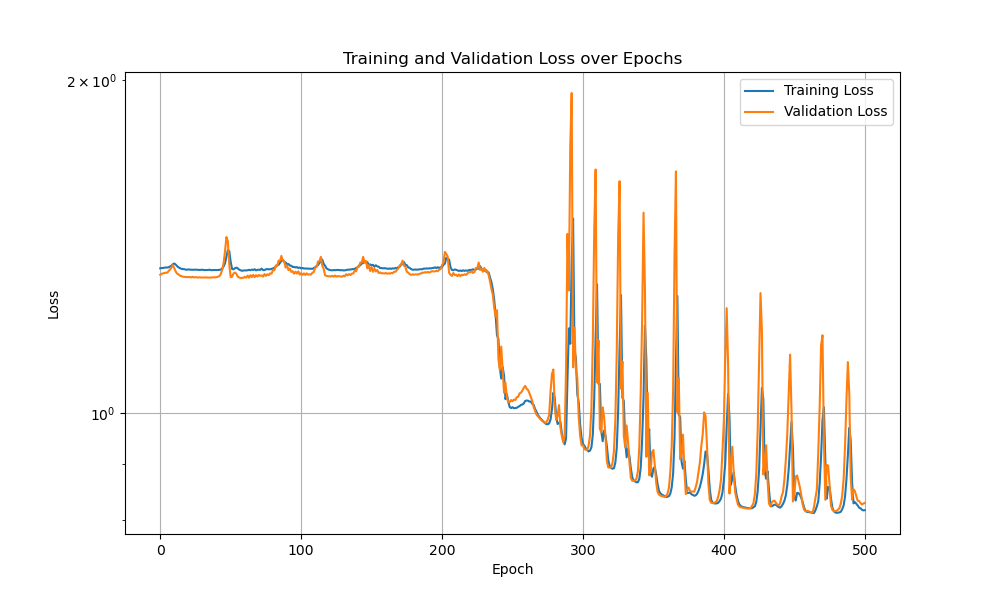

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss over Epochs")
plt.grid(True)
plt.yscale("log")
plt.show()


In [25]:
import Plotting.plotters_simple as plotters_simple

plot_points = points_tensor[::10]

plot_data_pairs = []
for point in plot_points:
    Mq_point, _, _ = dynamics.dynamical_matrices(rp, point, point)
    Aq_point = dynamics.input_matrix(rp, point)
    plot_data_pairs.append((point, Mq_point, Aq_point))

plot_points_tensor = torch.stack([pair[0] for pair in plot_data_pairs])           # Tensor of all points
mass_matrices_tensor = torch.stack([pair[1] for pair in plot_data_pairs])   # Tensor of all mass matrices
input_matrices_tensor = torch.stack([pair[2] for pair in plot_data_pairs])  # Tensor of all input matrices

# Create TensorDataset
plot_dataset = TensorDataset(plot_points_tensor, mass_matrices_tensor, input_matrices_tensor)
plot_dataloader = DataLoader(plot_dataset, batch_size=len(plot_dataset), shuffle=False, num_workers=0)

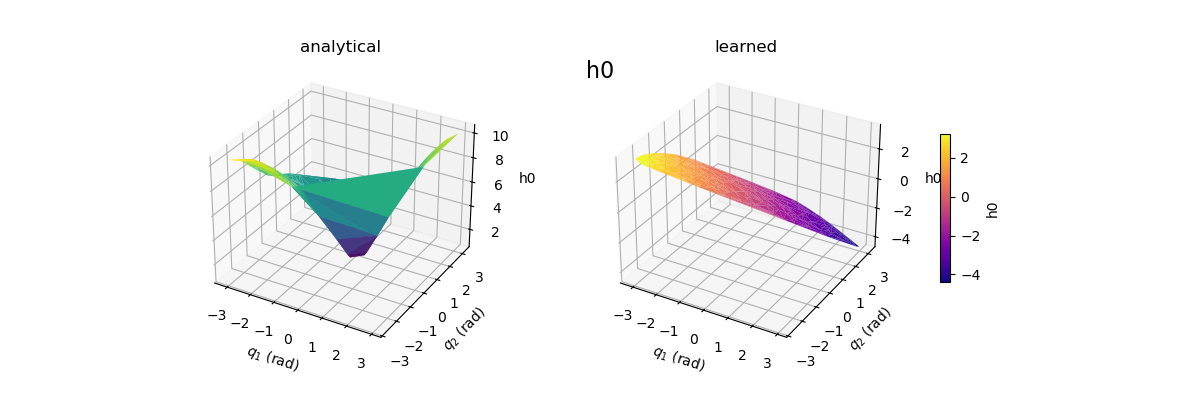

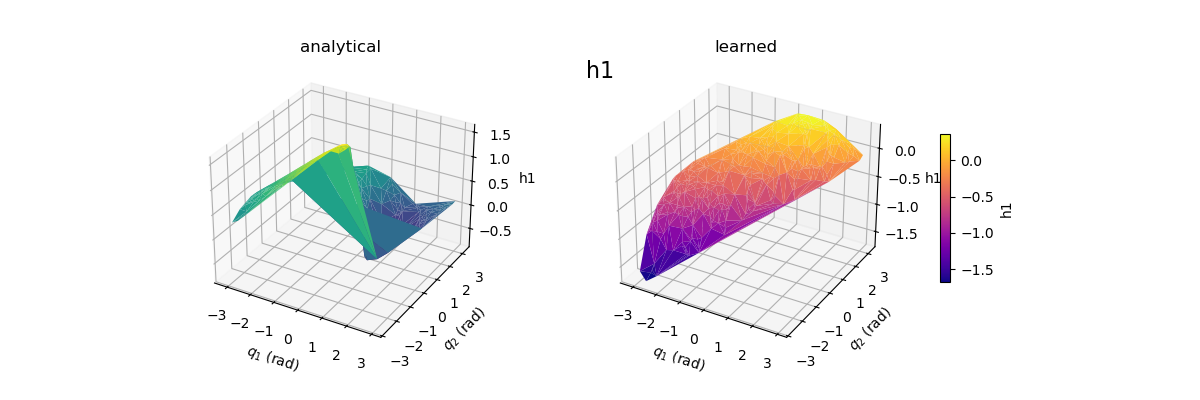

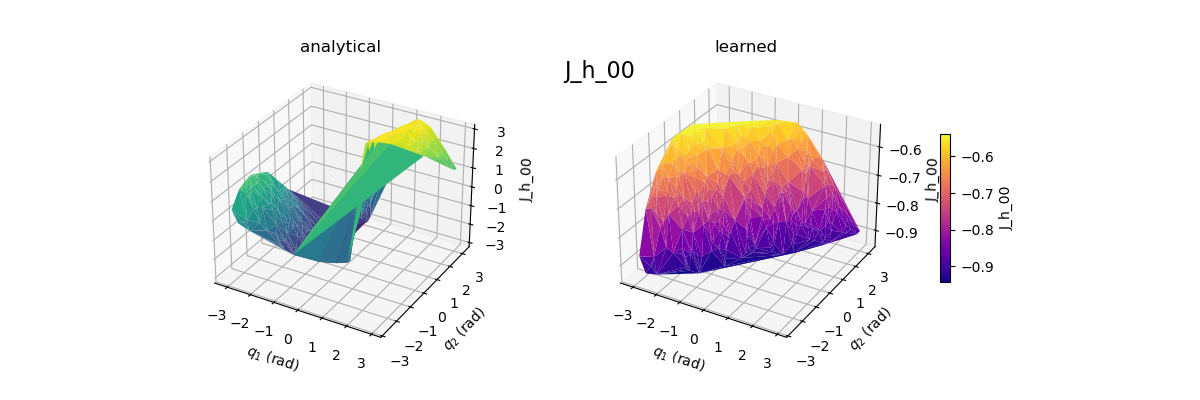

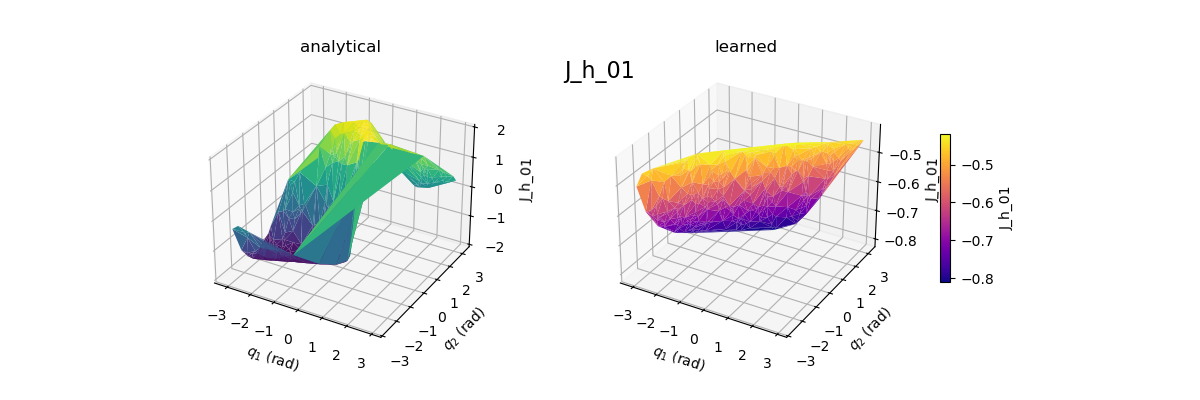

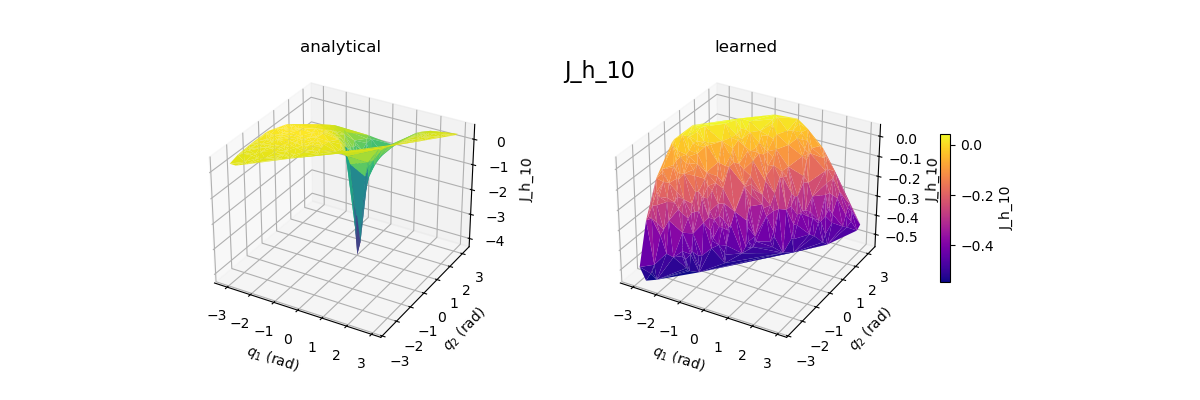

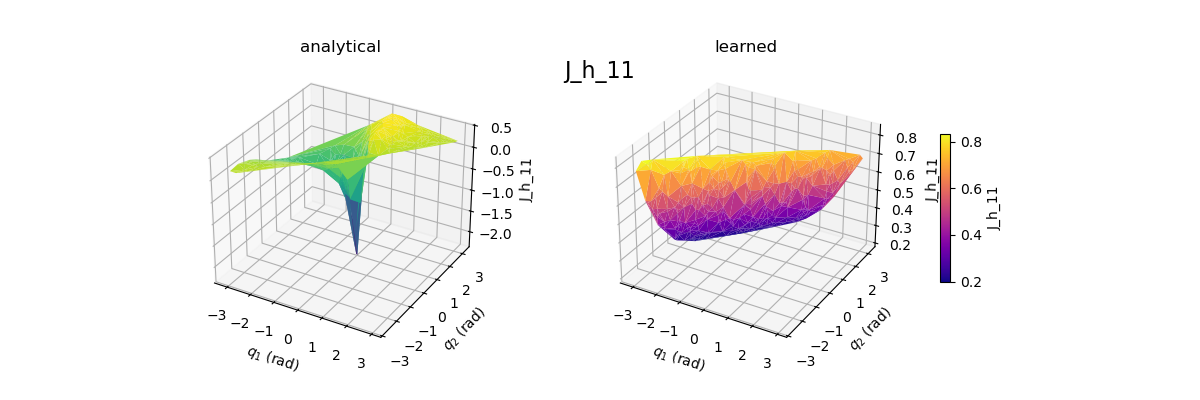

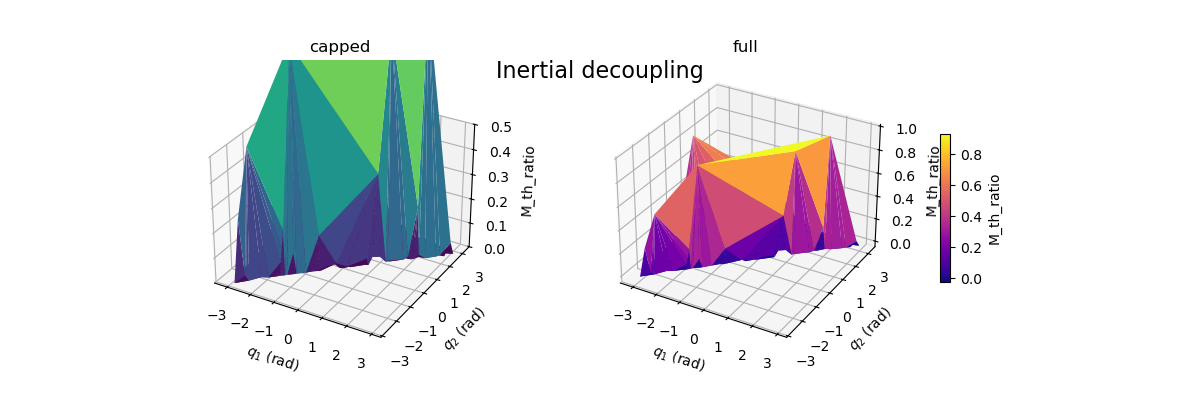

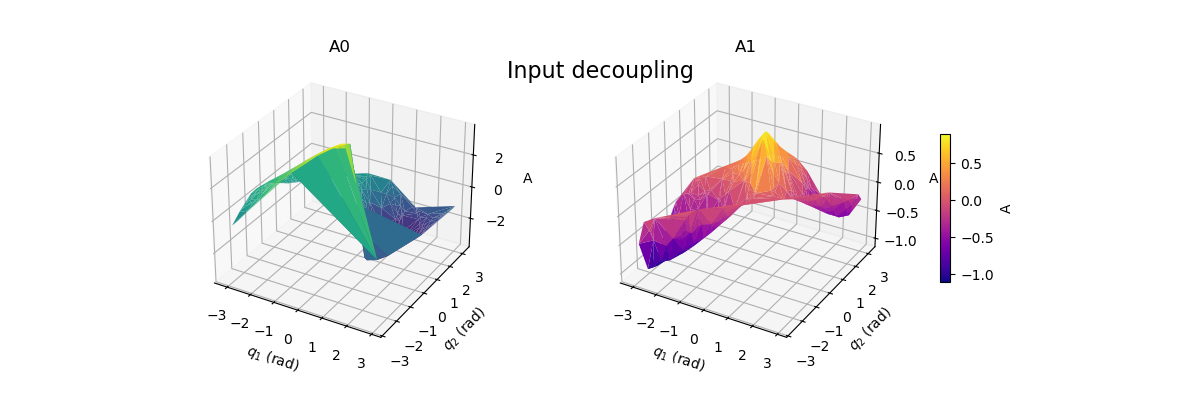

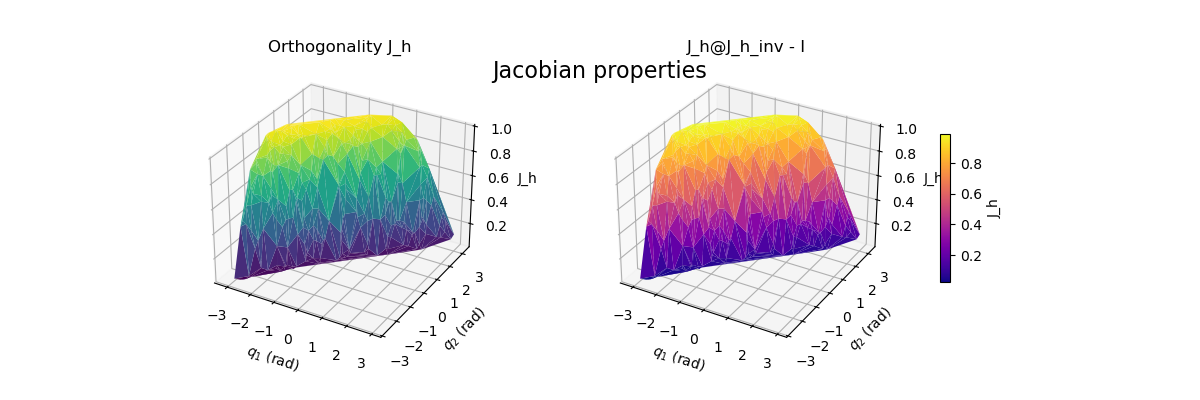

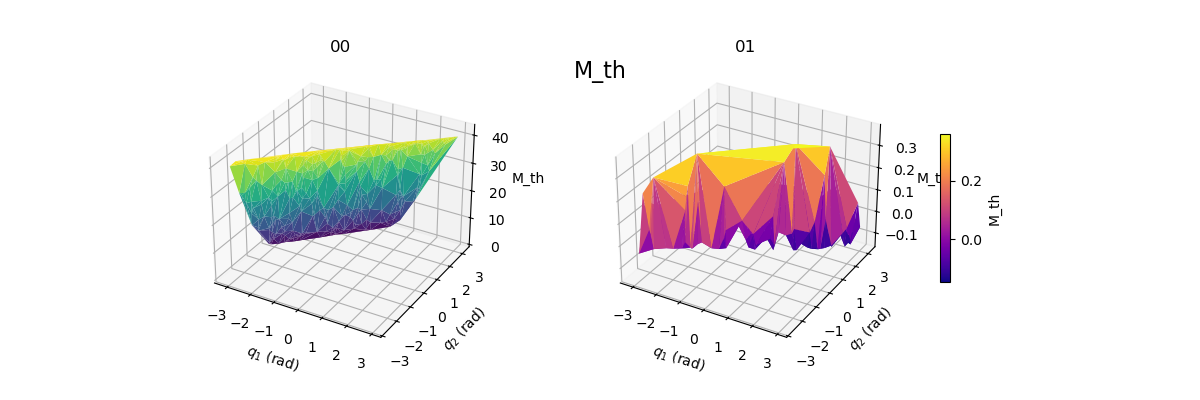

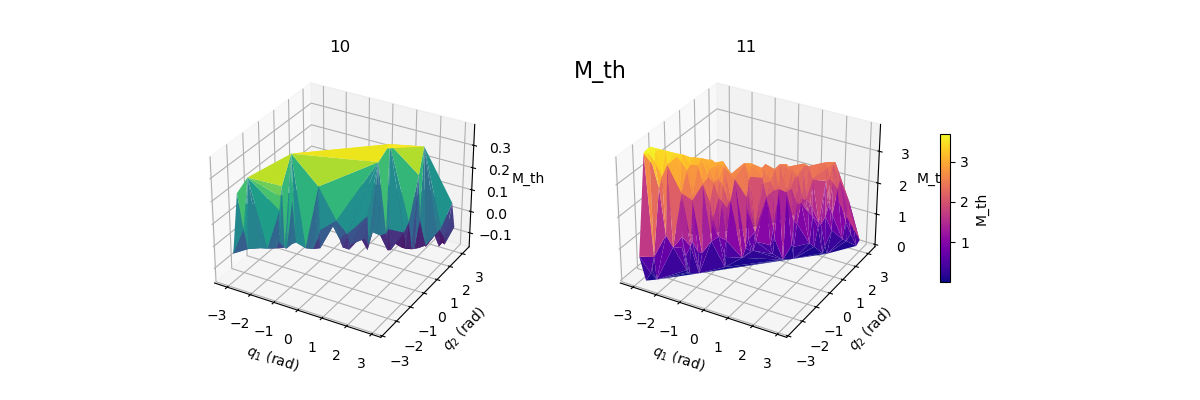

In [27]:


model.eval()
with torch.no_grad():
    for (q, M_q, A_q) in plot_dataloader:
        q = q.to(device)
        M_q = M_q.to(device)
        A_q = A_q.to(device)

        theta, J_h, q_hat, J_h_dec, J_h_ana = model(q)
        theta_ana = model.theta_ana(q)
        J_h_trans = torch.transpose(J_h, 1, 2)
        #J_h_inv = J_h_dec
        #J_h_inv_trans = torch.transpose(J_h_inv, 1, 2)
        J_h_inv = J_h_trans
        J_h_inv_trans = J_h
        M_th = J_h_inv_trans @ M_q @ J_h_inv
        A_th = (J_h_inv_trans @ A_q).squeeze(-1)

        off_dia = M_th[:, 0, 1]
        diag_elements = M_th[:, [0, 1], [0, 1]]
        diag_product = torch.sqrt(diag_elements[:, 0] * diag_elements[:, 1])# + 1e-8
        M_th_ratio = off_dia/diag_product

        J_ortho = J_h @ J_h_trans        
        identity_matrix = J_h @ J_h_inv  # Batch-wise multiplication
        l_J_inv = ((torch.eye(identity_matrix.size(-1), device=identity_matrix.device) - identity_matrix)**2).sum(dim=(1,2)) 
        l_J_ortho = ((torch.eye(identity_matrix.size(-1), device=identity_matrix.device) - J_ortho)**2).sum(dim=(1,2))

        
        plotters_simple.plot_3d_double(plot_points, theta_ana[:, 0], theta[:, 0], "h0", "analytical", "learned", "h0", device)
        plotters_simple.plot_3d_double(plot_points, theta_ana[:, 1], theta[:, 1], "h1", "analytical", "learned", "h1", device)

        plotters_simple.plot_3d_double(plot_points, J_h_ana[:, 0, 0], J_h[:, 0, 0], "J_h_00", "analytical", "learned", "J_h_00", device)
        plotters_simple.plot_3d_double(plot_points, J_h_ana[:, 0, 1], J_h[:, 0, 1], "J_h_01", "analytical", "learned", "J_h_01", device)
        plotters_simple.plot_3d_double(plot_points, J_h_ana[:, 1, 0], J_h[:, 1, 0], "J_h_10", "analytical", "learned", "J_h_10", device)
        plotters_simple.plot_3d_double(plot_points, J_h_ana[:, 1, 1], J_h[:, 1, 1], "J_h_11", "analytical", "learned", "J_h_11", device)

        plotters_simple.plot_3d_double(plot_points, M_th_ratio, M_th_ratio, "Inertial decoupling", "capped", "full", "M_th_ratio", device, z_limits = (0, 0.5))

        plotters_simple.plot_3d_double(plot_points, A_th[:, 0], A_th[:, 1], "Input decoupling", "A0", "A1", "A", device)

        plotters_simple.plot_3d_double(plot_points, l_J_ortho, l_J_inv, "Jacobian properties", "Orthogonality J_h", "J_h@J_h_inv - I", "J_h", device)
        
        plotters_simple.plot_3d_double(plot_points, M_th[:, 0, 0], M_th[:, 0, 1], "M_th", "00", "01", "M_th", device)
        plotters_simple.plot_3d_double(plot_points, M_th[:, 1, 0], M_th[:, 1, 1], "M_th", "10", "11", "M_th", device)
        